In [11]:
data_location = "/Users/youngjuchoi/Img_Caption/flickr8k"

usage: cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file target_file
       cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file ... target_directory


In [12]:
import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from pathlib import Path

#custom imports 
from dataloader import FlickrDataset, get_data_loader

In [13]:
#for image plot
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [14]:
#setting the constants
data_location = Path("./flickr8k") #relative path
BATCH_SIZE = 256
NUM_WORKER = 1

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(256),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location / "Images",
    captions_file = data_location / "captions.txt",
    transform=transforms
)

#writing the dataloader
data_loader = get_data_loader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
)

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

In [16]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False) #doesn't require backprop 
        
        modules = list(resnet.children())[:-1] #remove last fully-connected layer
        self.resnet = nn.Sequential(*modules) 
        self.embed = nn.Linear(resnet.fc.in_features, embed_size) #new linear layer

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1) # N x (appropriate dim)
        features = self.embed(features)
        return features

In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, drop_prob=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fcn = nn.Linear(hidden_size, vocab_size)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self, features, captions):
        #vectorize the caption
        embeds = self.embedding(captions[:,:-1])
        
        #concat the features and captions
        x = torch.cat((features.unsqueeze(1), embeds),dim=1) 
        x,_ = self.lstm(x)
        x = self.fcn(x)
        return x
    
    def generate_caption(self, inputs, hidden=None, max_len=20, vocab=None):
        # Inference part
        # Given the image features generate the captions
        batch_size = inputs.size(0)
        captions = []
        
        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.fcn(output)
            output = output.view(batch_size,-1)
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions]

In [18]:
class EncoderDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)
    
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [22]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [20]:
# Hyperparameters
embed_size = 400
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 0.0001
num_epochs = 2

# initialize model, loss etc
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/opt/homebrew/Caskroom/miniconda/base/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch:1/20, step:0/159, loss: 8.00630


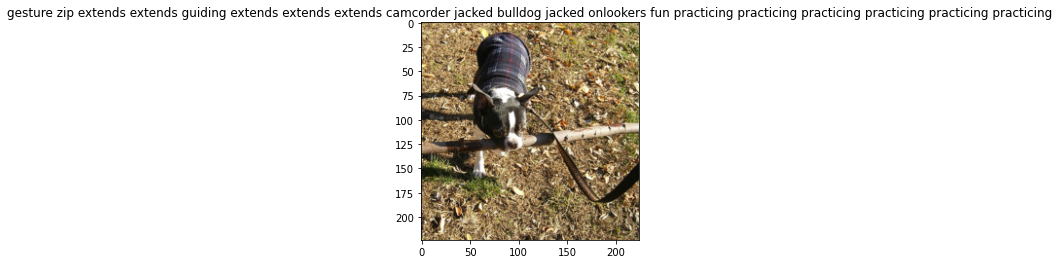

KeyboardInterrupt: 

In [23]:
num_epochs = 20
print_every = 20
total_len = len(data_loader)
for epoch in range(1, num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image, captions = image.to(device), captions.to(device)
        
        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        
        if (idx+1)%print_every == 0:
            print(f'Epoch:{epoch}/{num_epochs}, step:{idx}/{total_len}, loss: {loss:.5f}')
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()

PATH = "img_caption.pth"
torch.save(model.state_dict(), PATH) 